In [27]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [28]:
## Get the current working directory
current_directory = os.getcwd()
## Use a global variable for the path to the data
FILES_PATH = f"{current_directory}/data/"

Even though a notebook is not a viable solution for production-ready code, I decided to use a notebook to implement my code and present the results for this assignment. It makes it easier for the reader to follow and understand.

### Import datasets

In [29]:
fixtures_data = pd.read_csv(f"{FILES_PATH}fixtures.csv", delimiter=",")
odds_data = pd.read_csv(f"{FILES_PATH}odds.csv", delimiter=",")
players_data = pd.read_csv(f"{FILES_PATH}players.csv", delimiter=",")
results_data = pd.read_csv(f"{FILES_PATH}results.csv", delimiter=",")
startingXI_data = pd.read_csv(f"{FILES_PATH}startingXI.csv", delimiter=",")
teams_data = pd.read_csv(f"{FILES_PATH}teams.csv", delimiter=",")

In [30]:
datasets_dictionnary = {"fixture" : fixtures_data, "odds" : odds_data, "players" : players_data, "results" : results_data, "startingXI" : startingXI_data, "teams" : teams_data}

# Exploring the first season

# Data exploration and cleaning
Exploring the dataset and cleaning the data if needed

In [31]:
def flag_missing_duplicated_values(dict_files : dict) -> pd.DataFrame:
    """
    Flag missing or duplicated values in the imported datasets. 
    """
    missing_values_count = {}
    duplicated_values_count = {}

    for _name, _dataset in dict_files.items():
        if _dataset.isnull().sum().any():
            missing_values_count[_name] = 1
        else:
            missing_values_count[_name] = 0

        if _dataset.duplicated().any():
            duplicated_values_count[_name] = 1
        else:
            duplicated_values_count[_name] = 0

    df_missing_values_count = pd.DataFrame(missing_values_count.items(), columns = ["DatasetName", "MissingValuesCount"])
    df_duplicated_values_count = pd.DataFrame(missing_values_count.items(), columns = ["DatasetName", "DuplicatedValuesCount"])
    return df_missing_values_count.merge(df_duplicated_values_count, on = ["DatasetName"], how = "inner")
df_flag_anomalies = flag_missing_duplicated_values(datasets_dictionnary)

df_flag_anomalies

,DatasetName,MissingValuesCount,DuplicatedValuesCount
0,fixture,0,0
1,odds,0,0
2,players,0,0
3,results,0,0
4,startingXI,0,0
5,teams,0,0


There are no issues duplicated or NaN values.


We plot the numerical variables Home/Away Scores as well as the Home/Away Shots to potentially spot any outliers

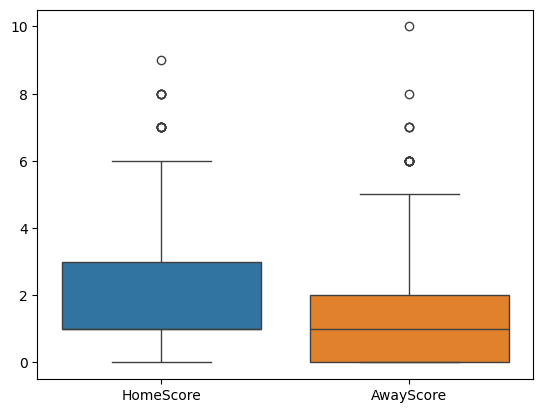

In [32]:
## Scores data box plot
sns.boxplot(data=results_data[["HomeScore", "AwayScore"]])
plt.show()

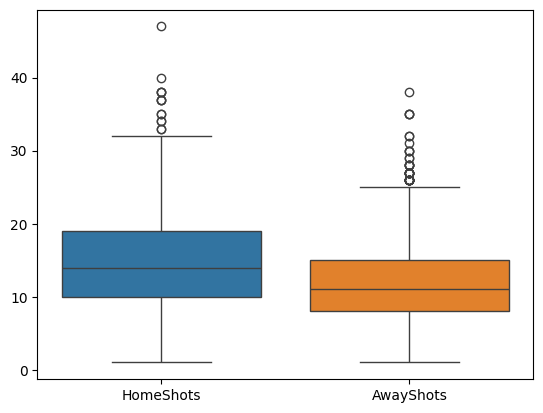

In [33]:
## Shots data box plot
sns.boxplot(data=results_data[["HomeShots", "AwayShots"]])
plt.show()

### **Values seem normal for a game of football.**

## Question 1: Which team won the league in the first season?

We start by adding the team names to the results datasets using the TeamID for more clarity

In [34]:
def add_team_name(df : pd.DataFrame, teams_data : pd.DataFrame) -> pd.DataFrame:
    """
    Merge the results dataset with the team dataset to add the name of the playing teams for every fixture. 
    """
    df = df.merge(teams_data, left_on="HomeTeamID", right_on = "TeamID", how="left")\
        .rename(columns = {"TeamName" : "HomeTeamName"})\
            .drop(columns="TeamID")

    return df.merge(teams_data, left_on="AwayTeamID", right_on = "TeamID", how="left")\
        .rename(columns = {"TeamName" : "AwayTeamName"})\
            .drop(columns="TeamID")

results_data = add_team_name(results_data, teams_data)

### Add the numbers of points scored in every game by both team
- 3 for a win
- 1 for a draw
- 0 for a loss

In [35]:
def add_points(score_team1 : int, score_team2 : int) -> int:
    """
    Returns 3 points if Team 1 scored more goals than Team 2
    1 point for a draw
    0 points if Team 2 scored more goals than Team 1
    """
    if score_team1>score_team2:
        return 3
    elif score_team1<score_team2:
        return 0
    else:
        return 1
## Creation of the variables HomePoints/AwayPoints which respectively represent the number of points earned by the Home and Away team in a game
results_data["HomePoints"] = results_data.apply(lambda x: add_points(x.HomeScore, x.AwayScore), axis=1)
results_data["AwayPoints"] = results_data.apply(lambda x: add_points(x.AwayScore, x.HomeScore), axis=1)

Filtering out the results season 2 to calculate the final ranking of season 1

In [36]:
results_data = results_data[results_data["SeasonID"]==1]

### Create a table with every team for every weekgame as index
We concatenate the results of the home and away teams into a single column for easier calculations.

<!-- We introduce the variable home_boolean for the first time, which will be frequently used throughout the project. Since we often work with datasets for both home and away results, the calculations — though similar — do not always use the same variable names.

- If home_boolean = True, the home dataset is used as input.
- If home_boolean = False, the away dataset is used as input. -->

In [37]:
def melt_results_dataset(df : pd.DataFrame) -> pd.DataFrame:
    """
    Concatenate the points scored for home and away into a single column PointsScored for easier calculations later on.
    """
    df_team_home = pd.melt(df, id_vars = ["HomeTeamID", "HomeTeamName","Gameweek"], value_vars = ["HomePoints"], value_name="PointsScored")\
    .rename(columns={"HomeTeamID":"TeamID", "HomeTeamName":"TeamName"})\
    .drop(columns="variable")

    df_team_away = pd.melt(df, id_vars = ["AwayTeamID", "AwayTeamName","Gameweek"], value_vars = ["AwayPoints"], value_name="PointsScored")\
    .rename(columns={"AwayTeamID":"TeamID", "AwayTeamName":"TeamName"})\
    .drop(columns="variable")
    
    return pd.concat((df_team_home, df_team_away)).sort_values(["Gameweek", "TeamID"], axis = 0)
    
df_all_team = melt_results_dataset(results_data)
df_all_team.head()

,TeamID,TeamName,Gameweek,PointsScored
0,1,Arlington,1,1
5,2,Anaheim,1,3
4,3,Atlanta,1,1
3,4,Baltimore,1,3
2,5,Boston,1,3


### Sum all the points scored per team after the end of season 1 and get the final ranking

In [38]:
def generate_final_ranking(df : pd.DataFrame) -> pd.DataFrame:
    """
    Generate the final ranking of a season by summing the total number of points scored by every team
    throughout the season. 
    """
    ## Aggregate per team and sum the total number of points scored by team
    df_ranking_season = df.groupby(["TeamID", "TeamName"]).agg(
        TotalPoints = ("PointsScored", "sum")
    ).sort_values(by="TotalPoints", ascending=False).reset_index()

    ## Creation of a ranking variable
    df_ranking_season["Ranking"] = np.arange(1, len(df_ranking_season)+1)

    return df_ranking_season

df_ranking_season1 = generate_final_ranking(df_all_team)
df_ranking_season1

,TeamID,TeamName,TotalPoints,Ranking
0,15,Miami,138,1
1,8,Cincinnati,125,2
2,4,Baltimore,117,3
3,19,New York S,113,4
4,5,Boston,106,5
5,27,Seattle,105,6
6,6,Chicago B,105,7
7,21,Oakland,96,8
8,7,Chicago H,95,9
9,24,St. Louis,94,10


## Miami won the league the first season with a total of 138 points.

## Question 2: At what point in the season did that team secure their league title?

According to the Premier League official website:


_"If any clubs finish with the same number of points, their position in the Premier League table is determined by goal difference, then the number of goals scored, then the team who collected the most points in the head-to-head matches, then who scored most away goals in the head-to-head."_

As it is impossible to predict the final goal difference, we will consider that a team has secured their title when their number of points exceeds the number of points of the second-placed team plus the maximum possible points remaining to be earned.

### Calculate the number of maximum points left to score for every gameweek

In [39]:
def left_points_to_score(df : pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the number of possible points to score for every gameweek (i.e. considering a team would win every game left). 
    e.g.: If there are 10 games left: 10*3 = 30 points possible. 
    """
    df_all_team["MaxPointsLeft"] = df_all_team.Gameweek.max()*3 - df_all_team.Gameweek*3
    return df_all_team
df_all_team = left_points_to_score(df_all_team)

### Calculate the number of total points for every team at every gameweek

In [40]:
def cumulative_points_gameweek(df : pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the number of total points for every team at every gameweek.
    """
    df["CumulativePoints"] = df.sort_values(by=["Gameweek", "TeamID"]).groupby(["TeamID", "TeamName"])["PointsScored"].cumsum().values
    return df
df_all_team = cumulative_points_gameweek(df_all_team)
df_all_team

,TeamID,TeamName,Gameweek,PointsScored,MaxPointsLeft,CumulativePoints
0,1,Arlington,1,1,159,1
5,2,Anaheim,1,3,159,3
4,3,Atlanta,1,1,159,1
3,4,Baltimore,1,3,159,3
2,5,Boston,1,3,159,3
...,...,...,...,...,...,...
753,24,St. Louis,54,0,0,94
752,25,San Diego,54,0,0,34
751,26,San Francisco,54,3,0,37
750,27,Seattle,54,3,0,105


### Add the cumulative number of points of the winner throughout the season 

In [41]:
def cumulative_points_gameweek_winner(df, winner_id = 15):
    """
    Add the cumulative number of points of the winner throughout the season.
    """
    return df.merge(df[df["TeamID"]==winner_id][["Gameweek", "CumulativePoints"]], on="Gameweek", suffixes=(("", "Winner")))

df_all_team = cumulative_points_gameweek_winner(df_all_team)
df_all_team

,TeamID,TeamName,Gameweek,PointsScored,MaxPointsLeft,CumulativePoints,CumulativePointsWinner
0,1,Arlington,1,1,159,1,3
1,2,Anaheim,1,3,159,3,3
2,3,Atlanta,1,1,159,1,3
3,4,Baltimore,1,3,159,3,3
4,5,Boston,1,3,159,3,3
...,...,...,...,...,...,...,...
1507,24,St. Louis,54,0,0,94,138
1508,25,San Diego,54,0,0,34,138
1509,26,San Francisco,54,3,0,37,138
1510,27,Seattle,54,3,0,105,138


### Calculate the difference of points between the winning team and every other team at every gameweek

In [42]:
def points_difference_teams(df : pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the difference of points between the winning team and every other team at every gameweek and 
    include and boolean variable when the difference of points with the winner exceeds the maximum number of points possible to score.
    """
    ## Difference of points between the winning team and the other teams
    df["DiffPointsWinner"] = df["CumulativePointsWinner"] - df["CumulativePoints"]
    
    ## Flag whenever a team will not be able to score more points than the winning team by the end of season 1
    df["CatchUpPossible"] = df.apply(lambda x: 1 if x.DiffPointsWinner>x.MaxPointsLeft else 0, axis = 1)
    return df
df_all_team = points_difference_teams(df_all_team)
df_all_team

,TeamID,TeamName,Gameweek,PointsScored,MaxPointsLeft,CumulativePoints,CumulativePointsWinner,DiffPointsWinner,CatchUpPossible
0,1,Arlington,1,1,159,1,3,2,0
1,2,Anaheim,1,3,159,3,3,0,0
2,3,Atlanta,1,1,159,1,3,2,0
3,4,Baltimore,1,3,159,3,3,0,0
4,5,Boston,1,3,159,3,3,0,0
...,...,...,...,...,...,...,...,...,...
1507,24,St. Louis,54,0,0,94,138,44,1
1508,25,San Diego,54,0,0,34,138,104,1
1509,26,San Francisco,54,3,0,37,138,101,1
1510,27,Seattle,54,3,0,105,138,33,1


### Find the first time every team will not be able to catch up with the winner

In [43]:
def find_winning_game_week(df, nbre_teams = len(teams_data)-1):
    """
    We sum the value of the boolean CatchUpPossible. If the sum is equal to the number of teams minus 1 (as the winner does not count)
    then we can confirm that the season 1 winner won the league at the corresponding gameweek.
    """
    ## Sum all the CatchUpPossible boolean per gameweek
    series_catchup_gameweek = df_all_team.groupby("Gameweek")["CatchUpPossible"].sum()

    ## Iterate to find when the sum is equal to number of teams - 1
    for pos, value in series_catchup_gameweek.items():
        if value == nbre_teams:
            return pos
        else:
            continue
winning_gameweek = find_winning_game_week(df_all_team)

print(f"Miami secured their league title at gameweek {winning_gameweek}!")

Miami secured their league title at gameweek 50!


### **Miami secured their league title at gameweek 50!** 

Indeed, we see that at gameweek 50, Cincinnati was 13 points behind with 4 games left to play, so 12 points maximum to score.

In [44]:
df_all_team[df_all_team["Gameweek"]==50]

,TeamID,TeamName,Gameweek,PointsScored,MaxPointsLeft,CumulativePoints,CumulativePointsWinner,DiffPointsWinner,CatchUpPossible
1372,1,Arlington,50,0,12,73,128,55,1
1373,2,Anaheim,50,1,12,31,128,97,1
1374,3,Atlanta,50,0,12,52,128,76,1
1375,4,Baltimore,50,3,12,111,128,17,1
1376,5,Boston,50,0,12,94,128,34,1
1377,6,Chicago B,50,0,12,93,128,35,1
1378,7,Chicago H,50,3,12,88,128,40,1
1379,8,Cincinnati,50,0,12,115,128,13,1
1380,9,Cleveland Queens,50,3,12,52,128,76,1
1381,10,Denver,50,0,12,31,128,97,1


## Question 3: What result was the biggest upset?

### Add the odds of every game to the results dataset.

In [45]:
def odds_results_merger(df_results : pd.DataFrame, df_odds : pd.DataFrame) -> pd.DataFrame:
    """
    Add the odds of every game to the results dataset.
    """
    return df_results.merge(df_odds, on="MatchID", how="left")
results_data_odds = odds_results_merger(results_data, odds_data)

### Check whether Home/Draw/Away odds are similar for a game.
We want to identify similar odds so we can properly flag "an upset". 

Example: If a win and a draw of the home team have the same odd and the teams actually drew. We might encounter a problem since the model could only consider a win as the right prediction and flag that as un upset.

In [46]:
def check_similar_odds(HomeOdd : float, DrawOdd : float, AwayOdd : float) -> int:
    """
    Check whether two or more odds are similar for a game. 
    """
    if HomeOdd==DrawOdd:
        return 1
    if AwayOdd==DrawOdd:
        return 1
    if HomeOdd==DrawOdd:
        return 1
    else:
        return 0
    
results_data_odds["SimilarOdds"] = results_data_odds.apply(lambda x: check_similar_odds(x.Home, x.Draw, x.Away), axis=1)
results_data_odds[results_data_odds["SimilarOdds"]==1]

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,HomeTeamName,AwayTeamName,HomePoints,AwayPoints,Home,Draw,Away,SimilarOdds
176,1,13,177,8,1,13,19,1,8,Cincinnati,New York S,1,1,1.87,4.04,4.04,1


There is only one game where two odds are similar.

### Odds encoding:
- 0 for the Home Team to win
- 1 for a draw
- 2 for the Away Team to win

We create a feature OddEncoded containing a list of the predicted game outcomes for every game in case two or more odds are similar.

In [47]:
def encode_odds(HomeOdd : float, DrawOdd : float, AwayOdd : float):
    """
    Encode the odds using 0, 1, 2 as Home Win, Draw, Away Win by returning the argmin of the minimum odd. 
    """
    odds_values = np.array([HomeOdd, DrawOdd, AwayOdd])
    return np.where(odds_values == odds_values.min())[0]

results_data_odds["OddEncoded"] = results_data_odds.apply(lambda x: encode_odds(x.Home, x.Draw, x.Away), axis=1)
results_data_odds.head()

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,HomeTeamName,AwayTeamName,HomePoints,AwayPoints,Home,Draw,Away,SimilarOdds,OddEncoded
0,1,1,1,7,1,17,1,1,12,Chicago H,Arlington,1,1,1.92,3.96,3.89,0,[0]
1,1,1,2,6,1,8,8,3,17,Chicago B,Cincinnati,0,3,2.16,3.88,3.23,0,[0]
2,1,1,3,5,5,21,9,1,7,Boston,Cleveland Queens,3,0,1.21,7.65,13.17,0,[0]
3,1,1,4,4,2,25,10,0,8,Baltimore,Denver,3,0,1.05,17.00,43.49,0,[0]
4,1,1,5,3,3,13,11,3,19,Atlanta,Detroit,1,1,3.12,3.60,2.32,0,[2]


### Results encoding using the same system as for the odds encoding

In [48]:
def encode_results(HomeScore : int, AwayScore : int) -> int:
    """
    Encode the results using 0, 1, 2 as Home Win, Draw, Away Win by comapring the number of goals scored during a game.  
    """
    if HomeScore>AwayScore:
        return 0
    elif HomeScore<AwayScore:
        return 2 
    else:
        return 1
    
results_data_odds["ResultEncoded"] = results_data_odds.apply(lambda x: encode_results(x.HomeScore, x.AwayScore), axis=1)

We flag an upset when the game outcome predicted by the odds does not match the real outcome

In [49]:
def flag_upset(df : pd.DataFrame) -> pd.DataFrame:
    """
    Flag an upset when the game outcome predicted by the odds does not match the real outcome. 
    """
    df["Upset"] = df.apply(lambda x: 0 if x.ResultEncoded in x.OddEncoded else 1, axis=1)
    return df

results_data_odds = flag_upset(results_data_odds) 

### Find biggest upset using the list of upset and the highest unexpected odd 
- Filter dataset for game considered as an "upset" as the odds did not predict the right outcome
- Find the odd corresponding to the real outcome of the game
- Find the highest value of the odds which then represents the biggest upset according to bookmakers

In [50]:
def find_right_odd(df : pd.DataFrame) -> pd.DataFrame:
    """
    Return in a new column the odd of the real game outcome.
    e.g.: if Home Win odd = 1.47 and the Home Team indeed won, RightOdd = 1.47. 
    """
    df["RightOdd"] = df.apply(lambda x: [x.Home, x.Draw, x.Away][int(x.ResultEncoded)], axis = 1)
    return df
results_data_odds = find_right_odd(results_data_odds)

Find the game considered as the biggest upset with the highest odd associated to the real outcome

In [51]:
biggest_upset=results_data_odds[results_data_odds["RightOdd"] == results_data_odds[results_data_odds["Upset"]==1]["RightOdd"].max()]

In [52]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(biggest_upset)

,SeasonID,Gameweek,MatchID,HomeTeamID,HomeScore,HomeShots,AwayTeamID,AwayScore,AwayShots,HomeTeamName,AwayTeamName,HomePoints,AwayPoints,Home,Draw,Away,SimilarOdds,OddEncoded,ResultEncoded,Upset,RightOdd
167,1,12,168,15,3,38,16,3,10,Miami,Milwaukee,1,1,1.03,23.35,75.22,0,[0],1,1,23.35


The biggest uspet happened at gameweek 12. 
- Home team is Miami, away team is Milwaukee. 
- The odd for Miami to win was 1.03, the draw was at 23.35 and for Milwaukee to win at 75.22. 

- The final outcome is a draw, which had a predicted probability of:
$$\frac{1}{23.35} = 4.28\%$$

We can actually see that Miami wasn't really lethal as they shot 38 times and scored 3 goals only.

3 goals, 10 shots for Milwaukee.